# Create entry points to spark

In [25]:
#from pyspark import SparkContext
#sc = SparkContext(master = 'local')

from pyspark.sql import SparkSession
spark = SparkSession.builder \
          .appName("Python Spark SQL basic example") \
          .config("spark.some.config.option", "some-value") \
          .getOrCreate()

## Logistic regression with pyspark

## Import data

In [120]:
df = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load("./data/bank.csv",header=True);
df.drop('day','month','poutcome').show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|     261|       1|   -1|       0| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|     151|       1|   -1|       0| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|      76|       1|   -1|       0| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|      92|       1|   -1|       0| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|     198|       1|   -1|       0| no|
+---+------------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+---+
o

In [119]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [32]:
df.count()

45211

In [33]:
df.distinct().count()

45211

In [89]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol())) 
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] 
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)
    
    data = data.withColumn('label',col(labelCol))
    
    return data.select('features','label')

In [90]:
# def get_dummy(df,categoricalCols,continuousCols):
    
#     from pyspark.ml import Pipeline
#     from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
#     from pyspark.sql.functions import col

#     indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
#                  for c in categoricalCols ]

#     # default setting: dropLast=True
#     encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
#                  outputCol="{0}_encoded".format(indexer.getOutputCol())) 
#                  for indexer in indexers ]

#     assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] 
#                                 + continuousCols, outputCol="features")
    

#     pipeline = Pipeline(stages=indexers + encoders + [assembler])

#     model=pipeline.fit(df)
#     data = model.transform(df)
    
#     return data

In [91]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'y'

from pyspark.sql.functions import col

data = get_dummy(cuse,catcols,num_cols,labelCol)

In [92]:
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[1,11,14,16,1...|   no|
|(29,[2,12,13,16,1...|   no|
|(29,[7,11,13,16,1...|   no|
|(29,[0,11,16,17,1...|   no|
|(29,[12,16,18,20,...|   no|
+--------------------+-----+
only showing top 5 rows



In [97]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[1,11,14,16,1...|   no|         0.0|
|(29,[2,12,13,16,1...|   no|         0.0|
|(29,[7,11,13,16,1...|   no|         0.0|
|(29,[0,11,16,17,1...|   no|         0.0|
|(29,[12,16,18,20,...|   no|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [98]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[1,11,14,16,1...|   no|(29,[1,11,14,16,1...|
|(29,[2,12,13,16,1...|   no|(29,[2,12,13,16,1...|
|(29,[7,11,13,16,1...|   no|(29,[7,11,13,16,1...|
|(29,[0,11,16,17,1...|   no|(29,[0,11,16,17,1...|
|(29,[12,16,18,20,...|   no|(29,[12,16,18,20,...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [99]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])
trainingData.show(5,False)
testData.show(5,False)

+-------------------------------------------------------------------------------------------------+-----+
|features                                                                                         |label|
+-------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-731.0,401.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-723.0,112.0,2.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-626.0,205.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-498.0,357.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-477.0,473.0,2.0,-1.0])|no   |
+-------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+--------------------

In [72]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])
trainingData.show(5,False)
testData.show(5,False)

+-------------------------------------------------------------------------------------------------+-----+
|features                                                                                         |label|
+-------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-723.0,112.0,2.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-626.0,205.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-518.0,46.0,5.0,-1.0]) |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-498.0,357.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-477.0,473.0,2.0,-1.0])|no   |
+-------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+--------------------

In [103]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [104]:
# !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [105]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [106]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [107]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



In [108]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.0987688
LogisticRegression_40448189c49bf2d83d07


In [109]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [110]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['no', 'yes']

In [111]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[15657,   379],
       [ 1410,   667]])

Confusion matrix, without normalization
[[15657   379]
 [ 1410   667]]


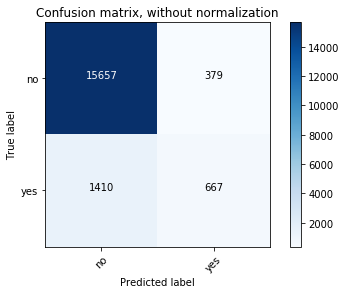

In [112]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 0.97636568  0.02363432]
 [ 0.67886375  0.32113625]]


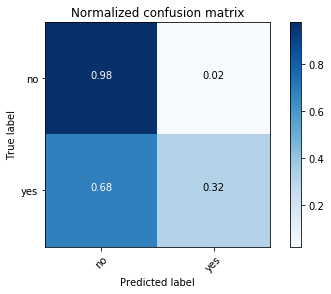

In [113]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [114]:
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(logr.regParam, [0, 0.5, 1, 2]).\
    addGrid(logr.elasticNetParam, [0, 0.5, 1]).\
    build()

In [115]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [116]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=logr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [117]:
cv_model = cv.fit(trainingData)

IllegalArgumentException: u'Field "indexedFeatures" does not exist.'

In [50]:
show_columns = [ 'label', 'prediction', 'probability']

In [51]:
predictions = cv_model.transform(testData)
predictions.select(show_columns).show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0.0  |0.0       |[0.9535754381507049,0.04642456184929507] |
|0.0  |0.0       |[0.9617550424601014,0.03824495753989859] |
|0.0  |0.0       |[0.9353089422145492,0.06469105778545074] |
|0.0  |0.0       |[0.9037808519456411,0.09621914805435886] |
|0.0  |0.0       |[0.9543207914710279,0.045679208528972066]|
+-----+----------+-----------------------------------------+
only showing top 5 rows



In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0986838


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [56]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['0.0', '1.0']

In [55]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[15673,   389],
       [ 1403,   694]])

Confusion matrix, without normalization
[[15673   389]
 [ 1403   694]]


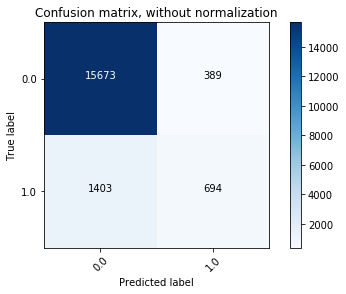

In [57]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 0.97578135  0.02421865]
 [ 0.66905103  0.33094897]]


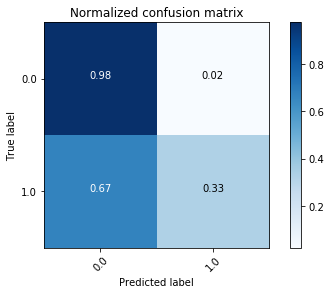

In [58]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Process categorical columns

The following code does three things with pipeline:

* **`StringIndexer`** all categorical columns
* **`OneHotEncoder`** all categorical index columns
* **`VectorAssembler`** all feature columns into one vector column

### Categorical columns

In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# categorical columns
categorical_columns = cuse.columns[0:3]

### Build StringIndexer stages

In [5]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='strindexed_' + c) for c in categorical_columns]
# encode label column and add it to stringindexer_stages
stringindexer_stages += [StringIndexer(inputCol='y', outputCol='label')]

### Build OneHotEncoder stages

In [6]:
onehotencoder_stages = [OneHotEncoder(inputCol='strindexed_' + c, outputCol='onehot_' + c) for c in categorical_columns]

### Build VectorAssembler stage

In [8]:
feature_columns = ['onehot_' + c for c in categorical_columns]
vectorassembler_stage = VectorAssembler(inputCols=feature_columns, outputCol='features') 

### Build pipeline model

In [9]:
# all stages
all_stages = stringindexer_stages + onehotencoder_stages + [vectorassembler_stage]
pipeline = Pipeline(stages=all_stages)

### Fit pipeline model

In [11]:
pipeline_model = pipeline.fit(cuse)

### Transform data

In [12]:
final_columns = feature_columns + ['features', 'label']
cuse_df = pipeline_model.transform(cuse).\
            select(final_columns)
            
cuse_df.show(5)

+-------------+----------------+----------------+-------------------+-----+
|   onehot_age|onehot_education|onehot_wantsMore|           features|label|
+-------------+----------------+----------------+-------------------+-----+
|(3,[2],[1.0])|       (1,[],[])|   (1,[0],[1.0])|(5,[2,4],[1.0,1.0])|  0.0|
|(3,[2],[1.0])|       (1,[],[])|   (1,[0],[1.0])|(5,[2,4],[1.0,1.0])|  0.0|
|(3,[2],[1.0])|       (1,[],[])|   (1,[0],[1.0])|(5,[2,4],[1.0,1.0])|  0.0|
|(3,[2],[1.0])|       (1,[],[])|   (1,[0],[1.0])|(5,[2,4],[1.0,1.0])|  0.0|
|(3,[2],[1.0])|       (1,[],[])|   (1,[0],[1.0])|(5,[2,4],[1.0,1.0])|  0.0|
+-------------+----------------+----------------+-------------------+-----+
only showing top 5 rows



## Split data into training and test datasets

In [13]:
training, test = cuse_df.randomSplit([0.8, 0.2], seed=1234)

## Build cross-validation model

### Estimator

In [14]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')

### Parameter grid

In [15]:
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(logr.regParam, [0, 0.5, 1, 2]).\
    addGrid(logr.elasticNetParam, [0, 0.5, 1]).\
    build()

### Evaluator

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

### Cross-validation model

In [17]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=logr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

### Fit cross-validation model

In [18]:
cv_model = cv.fit(cuse_df)

### Prediction

In [19]:
show_columns = ['features', 'label', 'prediction', 'rawPrediction', 'probability']

#### Prediction on training data

In [20]:
pred_training_cv = cv_model.transform(training)
pred_training_cv.select(show_columns).show(5, truncate=False)

+---------+-----+----------+------------------------------------------+---------------------------------------+
|features |label|prediction|rawPrediction                             |probability                            |
+---------+-----+----------+------------------------------------------+---------------------------------------+
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
+---------+-----+----------+------------------------------------------+---------------------------------

#### Prediction on test data

In [21]:
pred_test_cv = cv_model.transform(test)
pred_test_cv.select(show_columns).show(5, truncate=False)

+---------+-----+----------+------------------------------------------+---------------------------------------+
|features |label|prediction|rawPrediction                             |probability                            |
+---------+-----+----------+------------------------------------------+---------------------------------------+
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
|(5,[],[])|0.0  |1.0       |[-0.05602431718564116,0.05602431718564116]|[0.4859975829890087,0.5140024170109914]|
+---------+-----+----------+------------------------------------------+---------------------------------

## Intercept and coefficients of the regression model

In [22]:
print('Intercept: ' + str(cv_model.bestModel.intercept) + "\n"
     'coefficients: ' + str(cv_model.bestModel.coefficients))

Intercept: 0.05602431718564116
coefficients: [-0.280625539774,-0.799857435517,-1.18923909827,0.324994746147,-0.832954766261]


## Parameters from the best model

In [25]:
print('The best RegParam is: ', cv_model.bestModel._java_obj.getRegParam(), "\n",
     'The best ElasticNetParam is: cv_model.bestModel._java_obj.getElasticNetParam()')

The best RegParam is:  0.0 
 The best ElasticNetParam is: cv_model.bestModel._java_obj.getElasticNetParam()


# Linear regression with R

## Import Data (below is R code!)

```
#====== This is R code! =========
cuse = read.table('http://data.princeton.edu/wws509/datasets/cuse.dat', header = T)

# convert count data to binary data
not_using = rep(1:nrow(cuse), times=cuse$notUsing)
using = rep(1:nrow(cuse), times=cuse$using)
cuse_binary = cuse[c(not_using, using), 1:3]
cuse_binary$y = c(rep(0, length(not_using)), rep(1, length(using)))

# write data into a file
write.csv(cuse_binary, file='data/cuse_binary.csv', row.names = FALSE)
```

## Process categorical variables 
Process categorical variables so they have the same pattern as in pyspar. Element levels are in the descending order of element frequencies.

```
#====== This is R code! =========
cuse_binary$age = factor(cuse_binary$age, 
                         levels = names(sort(table(cuse_binary$age), decreasing = TRUE)))
cuse_binary$education = factor(cuse_binary$education,
                               levels = names(sort(table(cuse_binary$education), decreasing = TRUE)))
cuse_binary$wantsMore = factor(cuse_binary$wantsMore,
                               levels = names(sort(table(cuse_binary$wantsMore), decreasing = TRUE)))

# encode label column
cuse_binary$y = factor(cuse_binary$y,
                               levels = names(sort(table(cuse_binary$y))))
glm_cuse = glm(y~age + education + wantsMore, data = cuse_binary, family = binomial(link = "logit"))
```

## Results

```
#====== This is R code! =========
glm_cuse$coefficients

 (Intercept)     age25-29       age<25     age40-49 educationlow  wantsMoreno 
   0.7325613    0.5192319    0.9086135   -0.2806254    0.3249947   -0.8329548 
```